## Project Description

After a debt has been legally declared "uncollectable" by a bank, the account is considered to be "charged-off." But that doesn't mean the bank simply walks away from the debt. They still want to collect some of the money they are owed. In this project, you will look at a situation where a bank assigned delinquent customers to different recovery strategies based on the expected amount the bank believed it would recover from the customer. The goal for the data scientist is to determine in this non-random assignment whether the incremental amount the bank earns exceeded the additional cost of assigning customers to a higher recovery strategy.


Threshold assignments like this also one occur in medicine (above a certain temperature you get medicine), education (above a certain test score students get admitted to a special class), other areas of finance (above a certain wealth customers get different levels of service), and public sector (below a certain income someone is eligible for housing benefits). Regression discontinuity is an intuitive and useful analysis method in any situation of a threshold assignment.

## Project Tasks:

### Regression discontinuity: banking recovery

After a debt has been legally declared "uncollectable" by a bank, the account is considered to be "charged-off." But that doesn't mean the bank simply walks away from the debt. They still want to collect some of the money they are owed. The bank will score the account to assess the expected recovery amount, that is, the expected amount that the bank may be able to receive from the customer in the future (for a fixed time period such as one year). This amount is a function of the probability of the customer paying, the total debt, and other factors that impact the ability and willingness to pay.
The bank has implemented different recovery strategies at different thresholds (\$1000, \$2000, etc.) where the greater the expected recovery amount, the more effort the bank puts into contacting the customer. For low recovery amounts (Level 0), the bank just adds the customer's contact information to their automatic dialer and emailing system. For higher recovery strategies, the bank incurs more costs as they leverage human resources in more efforts to contact the customer and obtain payments. Each additional level of recovery strategy requires an additional $50 per customer so that customers in the Recovery Strategy Level 1 cost the company \$50 more than those in Level 0. Customers in Level 2 cost \$50 more than those in Level 1, etc.

**The big question:** does the extra amount that is recovered at the higher strategy level exceed the extra \$50 in costs? In other words, was there a jump (also called a "discontinuity") of more than \$50 in the amount recovered at the higher strategy level?

First, we'll load the banking dataset and look at the first few rows of data. This puts us in a good position to understand the dataset itself and begin thinking about how to analyze the data.



In [ ]:
### importing libraies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Let's load the data
df = pd.read_csv('/content/bank_data.csv')

In [ ]:
df.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882 entries, 0 to 1881
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1882 non-null   int64  
 1   expected_recovery_amount  1882 non-null   int64  
 2   actual_recovery_amount    1882 non-null   float64
 3   recovery_strategy         1882 non-null   object 
 4   age                       1882 non-null   int64  
 5   sex                       1882 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 88.3+ KB


## **Graphical exploratory data analysis**

The bank has implemented different recovery strategies at different thresholds (\$1000, \$2000, \$3000 and \$5000) where the greater the Expected Recovery Amount, the more effort the bank puts into contacting the customer. Zeroing in on the first transition (between Level 0 and Level 1) means we are focused on the population with Expected Recovery Amounts between \$0 and \$2000 where the transition between Levels occurred at \$1000. We know that the customers in Level 1 (expected recovery amounts between \$1001 and \$2000) received more attention from the bank and, by definition, they had higher Expected Recovery Amounts than the customers in Level 0 (between \$1 and \$1000).

Here's a quick summary of the Levels and thresholds again:

Level 0: Expected recovery amounts >\$0 and <=\$1000

Level 1: Expected recovery amounts >\$1000 and <=\$2000

The threshold of $1000 separates Level 0 from Level 1

A key question is whether there are other factors besides Expected Recovery Amount that also varied systematically across the \$1000 threshold. For example, does the customer age show a jump (discontinuity) at the \$1000 threshold or does that age vary smoothly? We can examine this by first making a scatter plot of the age as a function of Expected Recovery Amount for a small window of Expected Recovery Amount, \$0 to \$2000. This range covers Levels 0 and 1.

In [ ]:
df.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


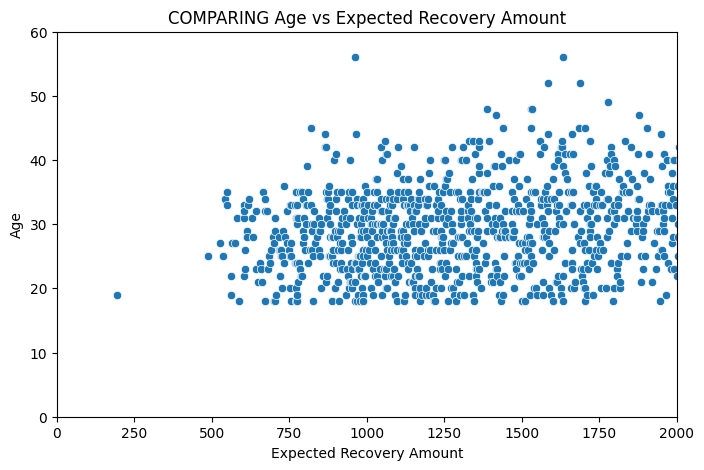

In [ ]:
# Scatter plot of Age vs. Expected Recovery Amount
plt.figure(figsize=(8,5))
sns.scatterplot(x='expected_recovery_amount',y='age',data=df)
plt.title('COMPARING Age vs Expected Recovery Amount')
plt.xlim(0, 2000)
plt.ylim(0, 60)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Age")
plt.show()

The Scatter Plot between Expected Recovery amount and Age shows there is no signifiance vary jump around \$1000.There is no relation between the Age and Expected Recovery Amount.

There is no discontinuity at \$1000 threshold between Age and Expected Recovery Amount

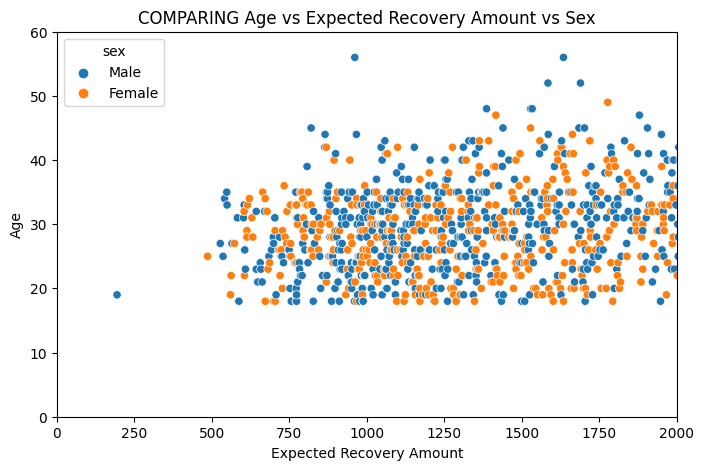

In [ ]:
# Scatter plot of Age vs. Expected Recovery Amount
plt.figure(figsize=(8,5))
sns.scatterplot(x='expected_recovery_amount',y='age',data=df,hue='sex')
plt.title('COMPARING Age vs Expected Recovery Amount vs Sex')
plt.xlim(0, 2000)
plt.ylim(0, 60)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Age")
plt.show()

There is no signifiance between Sex and Expected Recovery Amount. we conclude that the Expected Recovery amount and Age and sex has no relationship

### ***Statistical test: age vs. expected recovery amount***

We want to convince ourselves that variables such as age and sex are similar above and below the $1000 Expected Recovery Amount threshold. This is important because we want to be able to conclude that differences in the actual recovery amount are due to the higher Recovery Strategy and not due to some other difference like age or sex.



The scatter plot of age versus Expected Recovery Amount did not show an obvious jump around \$1000. We will be more confident in our conclusions if we do statistical analysis examining the average age of the customers just above and just below the threshold. We can start by exploring the range from \$900 to \$1100.

For determining if there is a difference in the ages just above and just below the threshold, we will use the Kruskal-Wallis test which is a statistical test that makes no distributional assumptions.

In [ ]:
era_900_1100 = df[(df['expected_recovery_amount']>=900)&(df['expected_recovery_amount']<=1100)]
by_recovery_strategy = era_900_1100.groupby(['recovery_strategy'])
by_recovery_strategy['age'].describe()


,count,mean,std,min,25%,50%,75%,max
recovery_strategy,,,,,,,,
Level 0 Recovery,89.0,27.224719,6.399135,18.0,23.0,26.0,31.0,56.0
Level 1 Recovery,95.0,28.684211,5.869617,18.0,24.0,29.0,33.0,43.0


H0: The mean of age is  not same for Level 0 Recovery and Level 1 Recovery


H1 : The mean of age is same for Level 0 Recovery and Level 1 Recovery

In [ ]:
from scipy import stats

Level_0_Recovery_age = era_900_1100.loc[df['recovery_strategy']=="Level 0 Recovery"]['age']
Level_1_Recovery_age = era_900_1100.loc[df['recovery_strategy']=="Level 1 Recovery"]['age']

result = stats.kruskal(Level_0_Recovery_age,Level_1_Recovery_age)
print(result)

KruskalResult(statistic=3.1513987711538896, pvalue=0.07586190694799404)


Since P-value greater than 0.05 so we can accept the null hypothesis.The mean age of two groups are not same

## **Statistical test: sex vs. expected recovery amount**

We were able to convince ourselves that there is no major jump in the average customer age just above and just below the $1000 threshold by doing a statistical test as well as exploring it graphically with a scatter plot.

We want to also test that the percentage of customers that are male does not jump as well across the \$1000 threshold. We can start by exploring the range of \$900 to \$1100 and later adjust this range.

We can examine this question statistically by developing cross-tabs as well as doing chi-square tests of the percentage of customers that are male vs. female.

In [ ]:
era_900_1100 = df[(df['expected_recovery_amount']>=900)&(df['expected_recovery_amount']<1100)]
crosstab = pd.crosstab(era_900_1100['sex'],era_900_1100['recovery_strategy'])
crosstab

recovery_strategy,Level 0 Recovery,Level 1 Recovery
sex,,
Female,32,39
Male,57,55


H0: The percentage of male customers does not jump across \$1000 thershold

H1: The percentage of male customers jumps across \$1000 thershold

In [ ]:
statistic,pvalue,dof,ex = stats.chi2_contingency(crosstab)
print(pvalue)

0.5377947810444592


Since P-value is greater than(0.05) we can accept the null hypothesis. so we can say that the percentage of male customers does not jump across \$1000 threshold

##  **Exploratory graphical analysis: recovery amount**

We are now reasonably confident that customers just above and just below the \$1000 threshold are, on average, similar in terms of their average age and the percentage that are male.


It is now time to focus on the key outcome of interest, the actual recovery amount.


A first step in examining the relationship between the actual recovery amount and the expected recovery amount is to develop a scatter plot where we want to focus our attention at the range just below and just above the threshold. Specifically, we will develop a scatter plot of Expected Recovery Amount (Y) vs. Actual Recovery Amount (X) for Expected Recovery Amounts between \$900 to \$1100. This range covers Levels 0 and 1. A key question is whether or not we see a discontinuity (jump) around the \$1000 threshold.

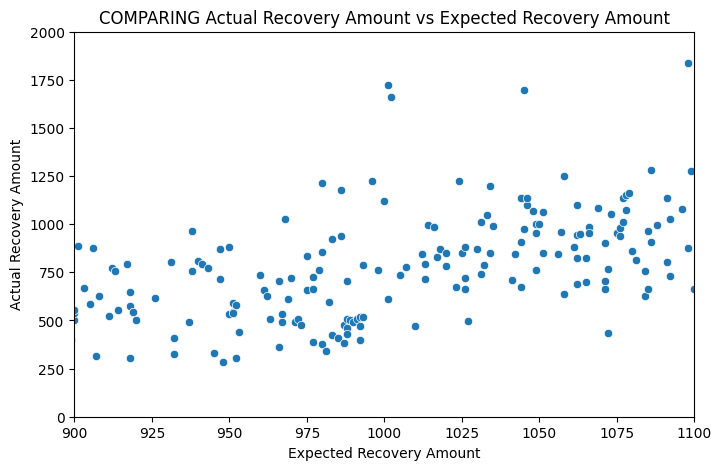

In [ ]:
# Scatter plot of Age vs. Expected Recovery Amount
plt.figure(figsize=(8,5))
sns.scatterplot(x='expected_recovery_amount',y='actual_recovery_amount',data=df)
plt.title('COMPARING Actual Recovery Amount vs Expected Recovery Amount')
plt.xlim(900, 1100)
plt.ylim(0, 2000)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Actual Recovery Amount")
plt.show()

The most expected recovery amount ranges between 950 to 1075.

## **Statistical analysis: recovery amount**

Just as we did with age, we can perform statistical tests to see if the actual recovery amount has a discontinuity above the \$1000 threshold. We are going to do this for two different windows of the expected recovery amount \$900 to \$1100 and for a narrow range of \$950 to \$1050 to see if our results are consistent.

Again, the statistical test we will use is the Kruskal-Wallis test, a test that makes no assumptions about the distribution of the actual recovery amount.

In [ ]:
# Compute average actual recovery amount just below and above the threshold
by_recovery_strategy['actual_recovery_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
recovery_strategy,,,,,,,,
Level 0 Recovery,89.0,623.017022,211.620859,282.855000,491.425000,575.435000,762.995000,1225.660000
Level 1 Recovery,95.0,952.750603,293.699060,433.199166,772.476088,906.498496,1058.007546,2053.290126


H0: We making an assumption actual recovery amount has discontinuity above \$1000 threshold

H1: We making an assumption actual recovery amount has no discontinuity above \$1000 threshold


In [ ]:

Level_0_Recovery_Actual = era_900_1100.loc[df['recovery_strategy']=="Level 0 Recovery"]['actual_recovery_amount']
Level_1_Recovery_Actual = era_900_1100.loc[df['recovery_strategy']=="Level 1 Recovery"]['actual_recovery_amount']

result = stats.kruskal(Level_0_Recovery_Actual,Level_1_Recovery_Actual)
print(result)

KruskalResult(statistic=65.37966302528878, pvalue=6.177308752803109e-16)


This test proves that actual recovery amount has discontinuity above 1000 threshold

In [ ]:
era_950_1050 = df[(df['expected_recovery_amount']>=950)&(df['expected_recovery_amount']<=1050)]


H0: We making an assumption actual recovery amount has discontinuity above \$1000 threshold

H1: We making an assumption actual recovery amount has no discontinuity above \$1000 threshold


In [ ]:
Level_0_Recovery_Actual = era_950_1050.loc[df['recovery_strategy']=="Level 0 Recovery"]['actual_recovery_amount']
Level_1_Recovery_Actual = era_950_1050.loc[df['recovery_strategy']=="Level 1 Recovery"]['actual_recovery_amount']

result = stats.kruskal(Level_0_Recovery_Actual,Level_1_Recovery_Actual)
print(result)

KruskalResult(statistic=30.9924872487249, pvalue=2.5902913533269003e-08)


## Regression modeling: no threshold

We now want to take a regression-based approach to estimate the impact of the program at the $1000 threshold using the data that is just above and just below the threshold. In order to do that, we will build two models. The first model does not have a threshold while the second model will include a threshold.

The first model predicts the actual recovery amount (outcome or dependent variable) as a function of the expected recovery amount (input or independent variable). We expect that there will be a strong positive relationship between these two variables.

In [ ]:
import statsmodels.api as sm

# Define X and y
X = era_900_1100['expected_recovery_amount']
y = era_900_1100['actual_recovery_amount']

# Add a constant to get an intercept
X = sm.add_constant(X)

# Fit the resgression line using 'OLS'
lr = sm.OLS(y,X).fit()



In [ ]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.261
Model:                                OLS   Adj. R-squared:                  0.256
Method:                     Least Squares   F-statistic:                     63.78
Date:                    Fri, 06 Oct 2023   Prob (F-statistic):           1.56e-13
Time:                            18:53:24   Log-Likelihood:                -1278.9
No. Observations:                     183   AIC:                             2562.
Df Residuals:                         181   BIC:                             2568.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -1978.7597    347.741     -5.690      0.000   -2664.907   -1292.612
expected_recovery_amount     2.7577      0.345      7.986      0.000       2.076       3.439
==============================================================================
Omnibus:                       64.493   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.818
Skew:                           1.463   Prob(JB):                     4.47e-41
Kurtosis:                       6.977   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Regression modeling: adding true threshold

From the first model, we see that the regression coefficient is statistically significant for the expected recovery amount and the adjusted R-squared value was about 0.26. As we saw from the graph, on average the actual recovery amount increases as the expected recovery amount increases. We could add polynomial terms of expected recovery amount (such as the squared value of expected recovery amount) to the model but, for the purposes of this practice, let's stick with using just the linear term.


The second model adds an indicator of the true threshold to the model. If there was no impact of the higher recovery strategy on the actual recovery amount, then we would expect that the relationship between the expected recovery amount and the actual recovery amount would be continuous.

In [ ]:
# Create indicator (0 or 1) for expected recovery amount >= $1000
df['indicator_1000'] = np.where(df['expected_recovery_amount']<1000, 0, 1)
era_900_1100 = df.loc[(df['expected_recovery_amount']<1100) &
                      (df['expected_recovery_amount']>=900)]

# Define X and y
X = era_900_1100[['expected_recovery_amount','indicator_1000']]
y = era_900_1100['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.314
Model:                                OLS   Adj. R-squared:                  0.307
Method:                     Least Squares   F-statistic:                     41.22
Date:                    Fri, 06 Oct 2023   Prob (F-statistic):           1.83e-15
Time:                            18:53:24   Log-Likelihood:                -1272.0
No. Observations:                     183   AIC:                             2550.
Df Residuals:                         180   BIC:                             2560.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        3.3440    626.274      0.005      0.996   -1232.440    1239.128
expected_recovery_amount     0.6430      0.655      0.981      0.328      -0.650       1.936
indicator_1000             277.6344     74.043      3.750      0.000     131.530     423.739
==============================================================================
Omnibus:                       65.977   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.537
Skew:                           1.510   Prob(JB):                     3.12e-41
Kurtosis:                       6.917   Cond. No.                     3.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Regression modeling: adjusting the window

The regression coefficient for the true threshold was statistically significant with an estimated impact of around \$278 and a 95 percent confidence interval of \$132 to \$424. This is much larger than the incremental cost of running the higher recovery strategy which was \$50 per customer. At this point, we are feeling reasonably confident that the higher recovery strategy is worth the additional costs of the program for customers just above and just below the threshold.


Before showing this to our managers, we want to convince ourselves that this result wasn't due just to us choosing a window of \$900 to \$1100 for the expected recovery amount. If the higher recovery strategy really had an impact of an extra few hundred dollars, then we should see a similar regression coefficient if we choose a slightly bigger or a slightly smaller window for the expected recovery amount. Let's repeat this analysis for the window of expected recovery amount from \$950 to \$1050 to see if we get similar results.

In [ ]:
era_950_1050 = df[(df['expected_recovery_amount']>=950)&(df['expected_recovery_amount']<=1050)]

import statsmodels.api as sm

# Define X and y
X = era_950_1050['expected_recovery_amount']
y = era_950_1050['actual_recovery_amount']

# Add a constant to get an intercept
X = sm.add_constant(X)

# Fit the resgression line using 'OLS'
lr = sm.OLS(y,X).fit()

lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.238
Model:                                OLS   Adj. R-squared:                  0.230
Method:                     Least Squares   F-statistic:                     30.64
Date:                    Fri, 06 Oct 2023   Prob (F-statistic):           2.60e-07
Time:                            18:53:24   Log-Likelihood:                -702.76
No. Observations:                     100   AIC:                             1410.
Df Residuals:                          98   BIC:                             1415.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -4365.0780    928.299     -4.702      0.000   -6207.257   -2522.899
expected_recovery_amount     5.1385      0.928      5.535      0.000       3.296       6.981
==============================================================================
Omnibus:                       45.225   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.157
Skew:                           1.694   Prob(JB):                     2.68e-25
Kurtosis:                       6.960   Cond. No.                     3.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# Create indicator (0 or 1) for expected recovery amount >= $1000
df['indicator_1000'] = np.where(df['expected_recovery_amount']<1000, 0, 1)


era_950_1050 = df[(df['expected_recovery_amount']>=950)&(df['expected_recovery_amount']<=1050)]

# Define X and y
X = era_950_1050[['expected_recovery_amount','indicator_1000']]
y = era_950_1050['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.287
Model:                                OLS   Adj. R-squared:                  0.273
Method:                     Least Squares   F-statistic:                     19.55
Date:                    Fri, 06 Oct 2023   Prob (F-statistic):           7.33e-08
Time:                            18:53:24   Log-Likelihood:                -699.42
No. Observations:                     100   AIC:                             1405.
Df Residuals:                          97   BIC:                             1413.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -310.8225   1808.751     -0.172      0.864   -3900.692    3279.047
expected_recovery_amount     0.9510      1.854      0.513      0.609      -2.728       4.630
indicator_1000             285.5160    110.391      2.586      0.011      66.421     504.611
==============================================================================
Omnibus:                       39.881   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.700
Skew:                           1.568   Prob(JB):                     4.05e-19
Kurtosis:                       6.239   Cond. No.                     6.76e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""